In [33]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-09-22 12:59:00--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.106
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.2’

train-images-idx3-u 100%[===================>]  25.20M   105MB/s    in 0.2s    

2019-09-22 12:59:00 (105 MB/s) - ‘train-images-idx3-ubyte.gz.2’ saved [26421880/26421880]

--2019-09-22 12:59:05--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.170
Connecting to fashion-mnist.s3-website.eu-central-1.a

In [34]:
!ls

log			     t10k-labels-idx1-ubyte.gz.2
MNIST_Fashion		     train-images-idx3-ubyte.gz
sample_data		     train-images-idx3-ubyte.gz.1
t10k-images-idx3-ubyte.gz    train-images-idx3-ubyte.gz.2
t10k-images-idx3-ubyte.gz.1  train-labels-idx1-ubyte.gz
t10k-images-idx3-ubyte.gz.2  train-labels-idx1-ubyte.gz.1
t10k-labels-idx1-ubyte.gz    train-labels-idx1-ubyte.gz.2
t10k-labels-idx1-ubyte.gz.1


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [36]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/", one_hot = True)

mkdir: cannot create directory ‘MNIST_Fashion’: File exists
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz


In [0]:
#Training PArams
learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network params
image_dim = 784 #img sz is 28x28
Y_dimension = 10 # The number of classes
gen_hidd_dim = 256
disc_hidd_dim  = 256
z_noise_dim = 100

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim + Y_dimension, disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim + Y_dimension, gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [0]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_input")
Y_input = tf.placeholder(tf.float32, shape = [None, Y_dimension], name = "Labels")



In [0]:
def Discriminator(x,y):
  inputs = tf.concat(axis = 1, values = [x,y])
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(inputs, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output
  

In [0]:
#Generator NW
def Generator(x,y):
  inputs = tf.concat(axis = 1, values = [x,y])
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(inputs, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output
  

In [0]:
# building the GEN NW
output_Gen = Generator(z_input, Y_input) #G(z/y)
 
 # Building the Disc NW
real_output1_Disc, real_output_disc = Discriminator(x_input, Y_input) #implements D(x/y)
fake_output1_Disc, fake_output_disc = Discriminator(output_Gen, Y_input) # implements D(G(x/y))



In [0]:
#first kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc+ 0.0001)+tf.log(1.- fake_output_disc+0.0001))
  
with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc+ 0.0001)) # due to max log(D(G(x)))

  # T-board summary
  
  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)


In [0]:
# #second kind of loss
# with tf.name_scope("Discriminator_Loss") as scope:
#   Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels = tf.ones_like(real_output1_Disc)))
#   Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.zeros_like(fake_output1_Disc)))
#   Discriminator_Loss = Disc_real_loss + Disc_fake_loss

  
# with tf.name_scope("Genetator_Loss") as scope:
#   Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.ones_like(fake_output1_Disc)))
  
#   # Tensorboarf summary
  
# Disc_loss_real_summary = tf.summary.scalar('Disc_loss_real', Disc_real_loss)
# Disc_loss_fake_summary = tf.summary.scalar('Disc_loss_fake', Disc_fake_loss)
# Disc_loss_summary = tf.summary.scalar('Disc_total_loss', Discriminator_Loss)

# Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary])
# Gen_loss_total = tf.summary.scalar('Gen_loss', Generator_Loss)




In [0]:
  # Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)
  

In [53]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch, Y_label = mnist.train.next_batch(batch_size)
  
  #Generate noise to feed Discriminator
  z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, Y_input:Y_label, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise, Y_input:Y_label})  
  
  #Running the Discriminator summary
  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise, Y_input:Y_label})
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_loss, epoch)
  
  #Running the Generator summary
  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise, Y_input:Y_label})
  # Adding the Generator summary
  writer.add_summary(summary_Gen_loss, epoch)
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  
  


Steps: 0: Generator Loss: 1.2810556888580322, Discriminator Loss:1.4036788940429688
Steps: 2000: Generator Loss: 6.665197849273682, Discriminator Loss:0.02185380831360817
Steps: 4000: Generator Loss: 4.120672702789307, Discriminator Loss:0.13705849647521973
Steps: 6000: Generator Loss: 4.001176834106445, Discriminator Loss:0.15926459431648254
Steps: 8000: Generator Loss: 3.998939037322998, Discriminator Loss:0.1976121962070465
Steps: 10000: Generator Loss: 3.755772829055786, Discriminator Loss:0.37067463994026184
Steps: 12000: Generator Loss: 4.238238334655762, Discriminator Loss:0.17916974425315857
Steps: 14000: Generator Loss: 3.8317372798919678, Discriminator Loss:0.3688141107559204
Steps: 16000: Generator Loss: 3.7119901180267334, Discriminator Loss:0.4597961902618408
Steps: 18000: Generator Loss: 3.534891366958618, Discriminator Loss:0.38630104064941406
Steps: 20000: Generator Loss: 2.8810877799987793, Discriminator Loss:0.46687525510787964
Steps: 22000: Generator Loss: 2.32859945

In [52]:
print(x_batch.shape)
print(x_input.shape)
print(Y_input.shape)
print(Y_label.shape)
print(z_input.shape)
print(z_noise.shape)



(10, 784)
(?, 784)
(?, 10)
(10, 10)
(?, 100)
(128, 100)


In [0]:
def generate_plot(samples):
  fig = plt.figure(figsize = (4,4))
  gs = gridspec.GridSpec(4,4)
  gs.update(wspace = 0.05, hspace = 0.05)
  
  for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap = 'gray')
  return fig  


In [0]:
def create(inp):
  feature_map = { "t-shirt":0,
                 "trouser":1,
                 "pullover":2,
                 "dress":3,
                 "coat":4,
                 "sandal":5,
                 "sirt":6,
                 "sneaker":7,
                 "bag":8,
                 "ankle boot": 9
                }
  samples = 16
  z_noise = np.random.uniform(-1.,1.,size = [samples, z_noise_dim])
  #one hot encoding
  Y_label = np.zeros(shape = [samples, Y_dimension])
  Y_label[:, feature_map[inp]] = 1
  
  # run the traineg generator excluding Discriminator
  generated_samples = sess.run(output_Gen, feed_dict = {z_input:z_noise, Y_input:Y_label})
  #plot images
  
  generate_plot(generated_samples)


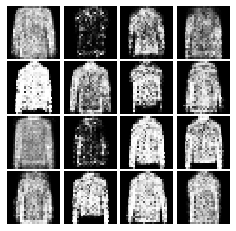

In [62]:
create("coat")

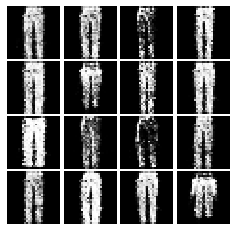

In [63]:
create('trouser')

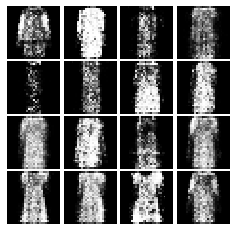

In [65]:
create('dress')